In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Загрузка датасета
DataFrame = pd.read_csv('S02-hw-dataset.csv', sep=',')
# Немного информации о данных
print(f'Первые 5 строк дата фрейма: \n{DataFrame.head()}\n')
print('Информацию о столбцах и типах дата фрейма')
print(DataFrame.info())
print(f'\n Базовые описательные статистики дата фрейма: \n{DataFrame.describe()}')

Первые 5 строк дата фрейма: 
   user_id   age country  purchases  revenue
0        1  25.0      FR          7      749
1        2  24.0      RU          5     1115
2        3  52.0      FR          7      399
3        4  31.0      RU          6      654
4        5   NaN      DE          6     1296

Информацию о столбцах и типах дата фрейма
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB
None

 Базовые описательные статистики дата фрейма: 
         user_id         age  purchases      revenue
count  41.000000   39.000000  41.000000    41.000000
mean   20.243902   36.512821   4.829268   820.048780
st

In [4]:
# Доля пропусков по столбцам
print("\nДоля пропущенных значений по столбцам:")
missing = DataFrame.isna().mean() * 100
print(missing)

# Полные дубликаты
duplicates = DataFrame.duplicated().sum()
print('\n', 'Полностью дублирующихся строк:', duplicates)


Доля пропущенных значений по столбцам:
user_id      0.000000
age          4.878049
country      0.000000
purchases    0.000000
revenue      0.000000
dtype: float64

 Полностью дублирующихся строк: 1


In [20]:
# Подозрительные значения

print("\nПоиск аномалий:")
# a) Нереалистичный возраст
age_issues = DataFrame[DataFrame['age'] > 100]
print(f"  • Нереалистичный возраст (>100): \n{age_issues}")
# b) Отрицательное количество покупок
neg_purchases = DataFrame[DataFrame['purchases'] < 0]
print(f"\n  • Отрицательное количество покупок: \n{neg_purchases}")
# c) Несоответствие между purchases и revenue
#    (revenue = 0, но purchases > 0) или наоборот
cond1 = (DataFrame['revenue'] == 0) & (DataFrame['purchases'] > 0)
cond2 = (DataFrame['revenue'] > 0) & (DataFrame['purchases'] == 0)
inconsistent = DataFrame[cond1 | cond2]
print(f"  • Противоречие purchases revenue: \n{inconsistent}\n")
print(f"  • Пропущен возраст:")
for index, row in DataFrame.iterrows():
    if pd.isna(row['age']):               # проверяем, NaN ли возраст
        print(f"user_id {row['user_id']} - возраст пропущен")


Поиск аномалий:
  • Нереалистичный возраст (>100): 
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785

  • Отрицательное количество покупок: 
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785
  • Противоречие purchases revenue: 
    user_id   age country  purchases  revenue
10       11  24.0      US          4        0

  • Пропущен возраст:
user_id 5 - возраст пропущен
user_id 13 - возраст пропущен


Было обнаружены проблеммы с данными. Нереалистичный возраст у user_id 6, у него же были обнаруженны отрицательное кол-во покупок, чего не может быть. У 11 юзера притиворечия purchases revenue. Также у двоих юзеров с id 5 и id 13 пропущен возраст.

In [26]:
# Частоты по странам
print("Частоты по странам:")
print(DataFrame['country'].value_counts())

# Считаем, сколько всего покупок и выручки в каждой стране
print("\nГруппировка по стране: сколько всего покупок и выручки")
result = DataFrame.groupby('country').agg({
    'purchases': 'sum',    # сколько всего покупок в этой стране
    'revenue': 'sum',      # сколько всего денег принесли пользователи из этой страны
    'user_id': 'count'     # сколько пользователей 
})

result = result.rename(columns={'user_id': 'users_count'} # Изменение названия столбца
print(result)

Частоты по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Группировка по стране: сколько всего покупок и выручки
         purchases  revenue  users_count
country                                 
CN               9     2108            2
DE              39     8673            6
FR              51     8111           12
RU              62    10271           13
US              37     4459            8


In [33]:
bins = [0, 18, 25, 35, 50, 100]                     # границы групп
labels = ['до 18', '18-25', '26-35', '36-50', '51+']  # названия

DataFrame['age_group'] = pd.cut(DataFrame['age'], 
                         bins=bins, 
                         labels=labels, 
                         include_lowest=True)

print("Распределение по возрастным группам:")
print(DataFrame['age_group'].head(10))
print(f"Кол-во в каждой возрастной категории: \n{DataFrame['age_group'].value_counts().sort_index()}")

Распределение по возрастным группам:
0    18-25
1    18-25
2      51+
3    26-35
4      NaN
5      NaN
6    36-50
7    26-35
8    36-50
9    18-25
Name: age_group, dtype: category
Categories (5, object): ['до 18' < '18-25' < '26-35' < '36-50' < '51+']
Кол-во в каждой возрастной категории: 
age_group
до 18     2
18-25    10
26-35    11
36-50     9
51+       6
Name: count, dtype: int64


In [37]:
print("\nСравнение возрастных групп по деньгам и покупкам")
result = DataFrame.groupby('age_group', observed=False).agg(
    users=('user_id', 'count'),
    total_revenue=('revenue', 'sum'),
    avg_revenue=('revenue', 'mean'),
    avg_purchases=('purchases', 'mean')
).round(0)

# Сортировка по среднему чеку
result = result.sort_values('avg_revenue', ascending=False)
print(result)


Сравнение возрастных групп по деньгам и покупкам
           users  total_revenue  avg_revenue  avg_purchases
age_group                                                  
до 18          2           2592       1296.0            6.0
26-35         11          10415        947.0            5.0
36-50          9           8508        945.0            4.0
51+            6           3580        597.0            5.0
18-25         10           5816        582.0            5.0


Группа «до 18» показывает самый высокий средний чек 1296, но это из-за одного ребёнка 5 лет — явная аномалия. Если её убрать, то больше всех в среднем тратят люди 26–35 и 36–50 лет примерно по 945–950. Самая большая и самая прибыльная группа — 26–35 лет, 11 человек, принесли больше 10 тысяч. Молодёжь 18–25 лет тратит меньше всех в среднем около 580–800, хотя покупок делает примерно столько же, сколько и остальные.
Вывод: основные деньги приносят люди 26–50 лет, а молодёжь тратит заметно меньше.

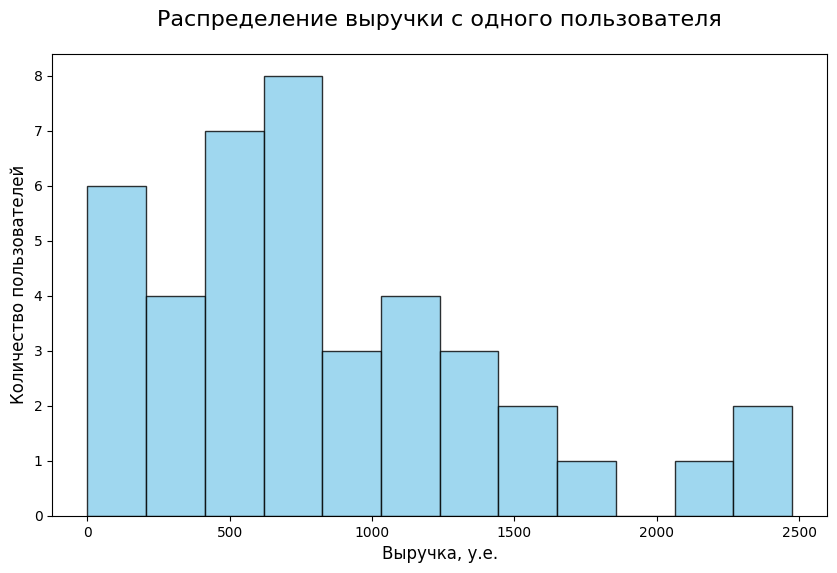

In [51]:
# Гистограмма
plt.figure(figsize=(10, 6))                    # размер окна (ширина, высота)

plt.hist(DataFrame['revenue'], 
         bins=12,                          # сколько столбиков
         edgecolor='black',              # чёрные границы столбиков
         color='skyblue',                     # цвет заливки
         alpha=0.8)                   # лёгкая прозрачность

# Подписи и заголовок
plt.title('Распределение выручки с одного пользователя', fontsize=16, pad=20)
plt.xlabel('Выручка, у.е.', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)

# Показываем график
plt.show()


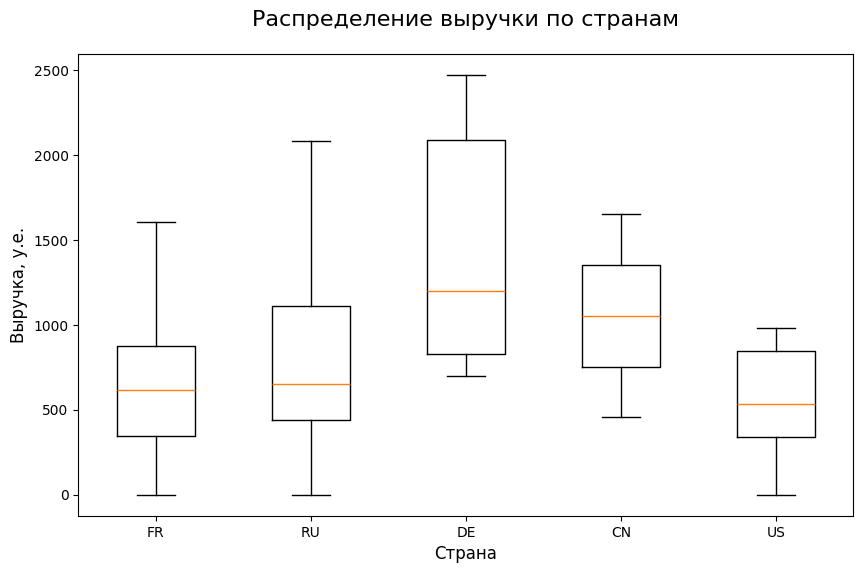

In [48]:
# Боксплот по группам
plt.figure(figsize=(10, 6))

plt.boxplot(
    [DataFrame[DataFrame['country'] == c]['revenue'] for c in DataFrame['country'].unique()],
    tick_labels=DataFrame['country'].unique()          # подписи под каждым боксом
)

# Подписи
plt.title('Распределение выручки по странам', fontsize=16, pad=20)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Выручка, у.е.', fontsize=12)

plt.show()

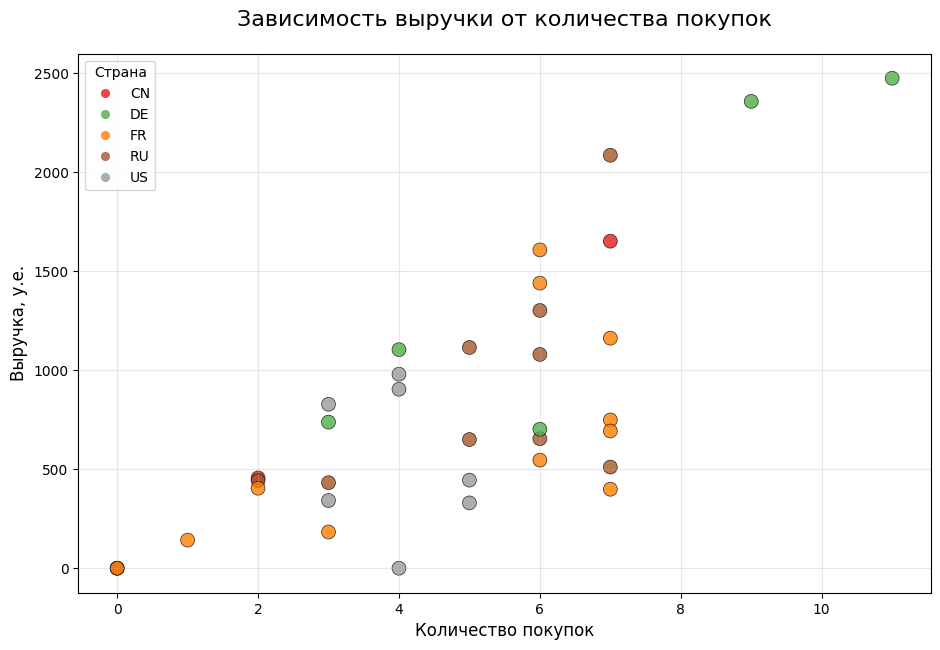

In [59]:
plt.figure(figsize=(11, 7))

# Scatter с цветом по странам
scatter = plt.scatter(
    x=df['purchases'],         # по оси X — количество покупок
    y=df['revenue'],          # по оси Y — выручка
    c=df['country'].astype('category').cat.codes,  # цвет по стране
    cmap='Set1',               # красивая палитра цветов
    s=100,                        # размер точек
    alpha=0.8,               # лёгкая прозрачность
    edgecolors='black',         # чёрная обводка
    linewidth=0.5
)

# Добавляем легенду 
handles, labels = scatter.legend_elements()
country_names = df['country'].astype('category').cat.categories
legend = plt.legend(handles, country_names, title='Страна', loc='upper left')

plt.title('Зависимость выручки от количества покупок', fontsize=16, pad=20)
plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Выручка, у.е.', fontsize=12)

# Сетка
plt.grid(True, alpha=0.3)
# Cохранение графиков в папку homeworks/HW02/figures/
plt.savefig('figures/Dependence_of_revenue_on_the_number_of_purchases.png', dpi=300, bbox_inches='tight')
plt.show()